In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
import itertools
import warnings
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error


# Checking data 

In [2]:
# Load data
df = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\AVG_Gas.csv")

df["Time Period (T)"] = pd.to_datetime(df["Time Period (T)"], format="%Y-%m-%d")
df = df.sort_values("Time Period (T)").reset_index(drop=True)
display(df.head())

,Time Period (T),Home charging (G),Electric car (G),Hybrid electric (G),Company car tax rate (%),Consumer confidence (E),Economic climate perception (E),Willingness to buy (E),Major purchases sentiment (E),Gasoline (Euro95) - Average price (F),Diesel - Average price (F),Total vehicles sold (Target)
0,2007-01-01,0,1,0,22,20.0,37.0,9.0,8.0,1.303032,0.970000,31
1,2007-02-01,0,0,0,22,20.0,37.0,9.0,8.0,1.325357,0.990000,39
2,2007-03-01,0,0,0,22,20.0,37.0,9.0,8.0,1.379032,1.006323,123
3,2007-04-01,0,0,0,22,20.0,37.0,9.0,8.0,1.426500,1.030600,62
4,2007-05-01,0,2,0,22,18.0,32.0,9.0,7.4,1.466516,1.032323,84


# Exploring PCA from dataset 

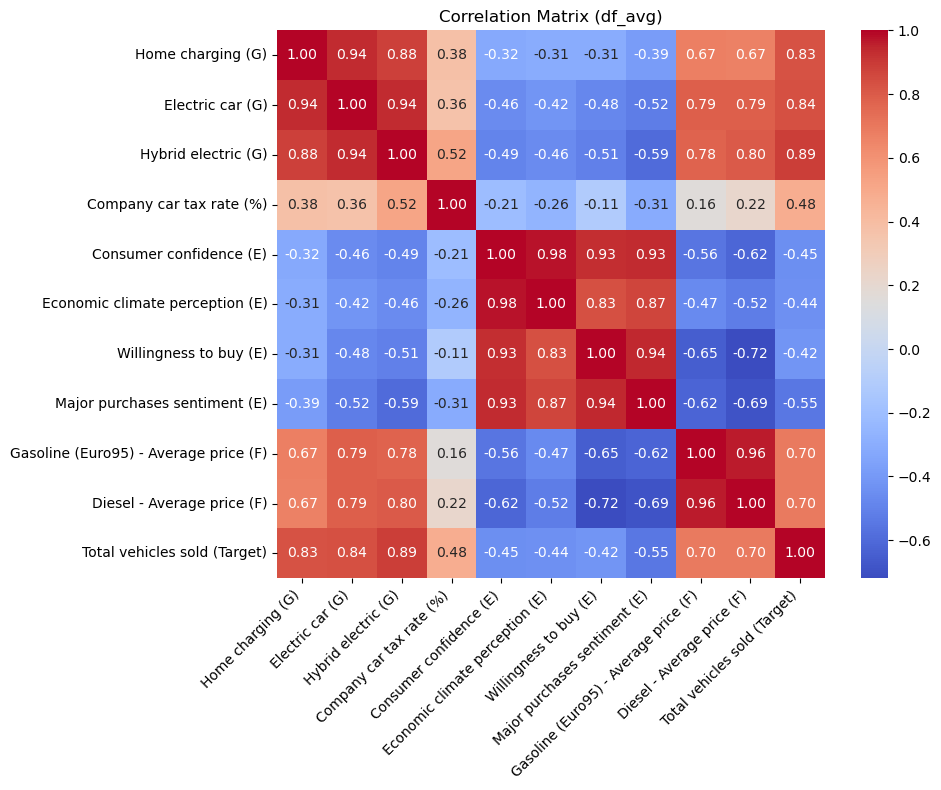

In [3]:
# Compute correlation matrix for df_avg
corr_matrix_avg = df.select_dtypes(include=['number']).corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_avg, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (df_avg)")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [5]:
# Create a DataFrame for explained variance using already defined variables
explained_variance = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'Explained Variance Ratio': pca.explained_variance_ratio_,
    'Cumulative Variance': np.cumsum(pca.explained_variance_ratio_)
})

display(explained_variance)

# Plot Scree plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(pca.explained_variance_ratio_) + 1),
    np.cumsum(pca.explained_variance_ratio_),
    marker='o'
)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.title("Cumulative Explained Variance by Principal Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Get PCA components (loadings)
loadings = pd.DataFrame(
    pca.components_[:3],  # PC1, PC2, PC3
    columns=features.columns,
    index=['PC1', 'PC2', 'PC3']
)

# Compute combined influence: sum of absolute loadings for PC1-PC3
combined_influence = loadings.abs().sum(axis=0).sort_values(ascending=False)

# Top 5 variables
top5 = combined_influence.head(5)
print("Top 5 variables (PC1-PC3 combined influence):")
print(top5)


NameError: name 'pca' is not defined

> looking at the data we see that the top 5 rows are as follows:

# Data workflow

## PLot target variable

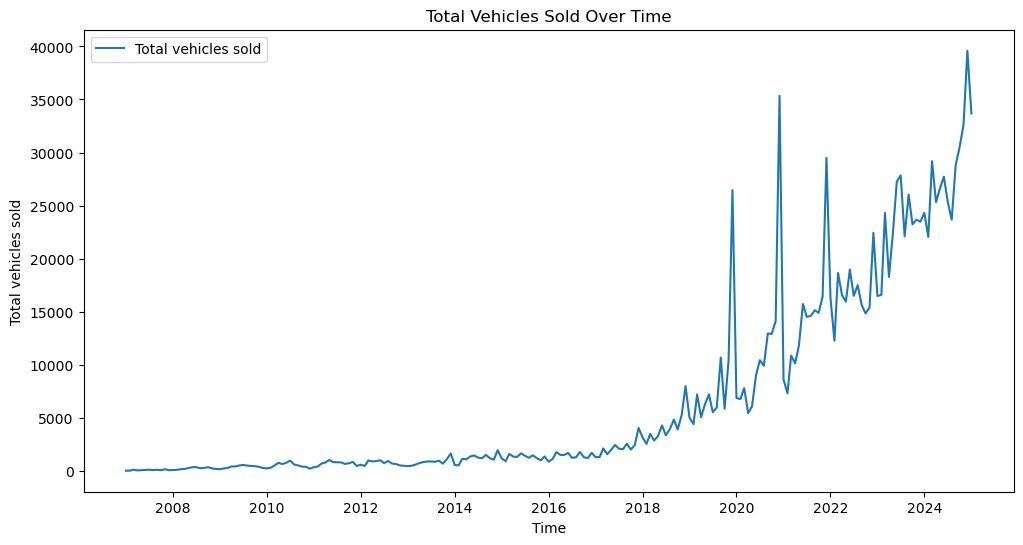

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(df["Time Period (T)"], df["Total vehicles sold (Target)"], label="Total vehicles sold")
plt.xlabel("Time")
plt.ylabel("Total vehicles sold")
plt.title("Total Vehicles Sold Over Time")
plt.legend()
plt.show()

> Alot of varience, lets add box cox 

Optimal lambda for Box-Cox: -0.0021


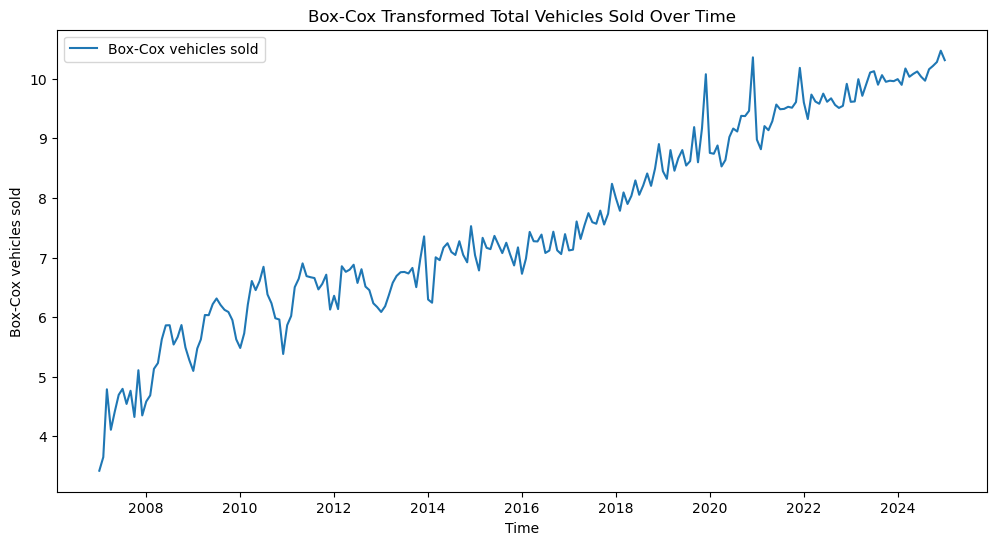

In [8]:
from scipy.stats import boxcox

# Select the target column
target_col = 'Total vehicles sold (Target)'
y = df[target_col].values

# Box-Cox requires all values > 0
if (y <= 0).any():
    raise ValueError("Box-Cox transformation requires all values to be positive.")

# Perform Box-Cox transformation
y_boxcox, fitted_lambda = boxcox(y)

# Add transformed values to the dataframe
df['BoxCox vehicles sold (Target)'] = y_boxcox

print(f"Optimal lambda for Box-Cox: {fitted_lambda:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(df["Time Period (T)"], y_boxcox, label="Box-Cox vehicles sold")
plt.xlabel("Time")
plt.ylabel("Box-Cox vehicles sold")
plt.title("Box-Cox Transformed Total Vehicles Sold Over Time")
plt.legend()
plt.show()



Little les varience 

### Check for stationality

The variencie is much better now, however there is still an upward trend and some seasonality visable in the data, to test the stationality i will performing a unit root test. 

there are several unit root tests available, such as the Augmented Dickey-Fuller (ADF) test, the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test, and the Phillips-Perron (PP) test. I will be using the ADF test, which is a widely used test for stationarity in time series data. 

In [9]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test on the BoxCox-transformed target
result = adfuller(df['BoxCox vehicles sold (Target)'])

print("ADF Statistic: {:.4f}".format(result[0]))
print("p-value: {:.4f}".format(result[1]))
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if result[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

ADF Statistic: -0.8015
p-value: 0.8187
Critical Value (1%): -3.4630
Critical Value (5%): -2.8759
Critical Value (10%): -2.5744
The series is likely non-stationary (fail to reject H0).


> With an ADF statistic of -0.8015, and a high p-value of 0.8187, we have failed to reject the null hypothesis meaning the series still likely contains a unit root (i.e. it's non-stationary) even after applying Box-Cox.

my next step is to apply a first difference to the data to remove the trend, and then re-evaluate stationarity using the ADF test again.

### Apply first difference

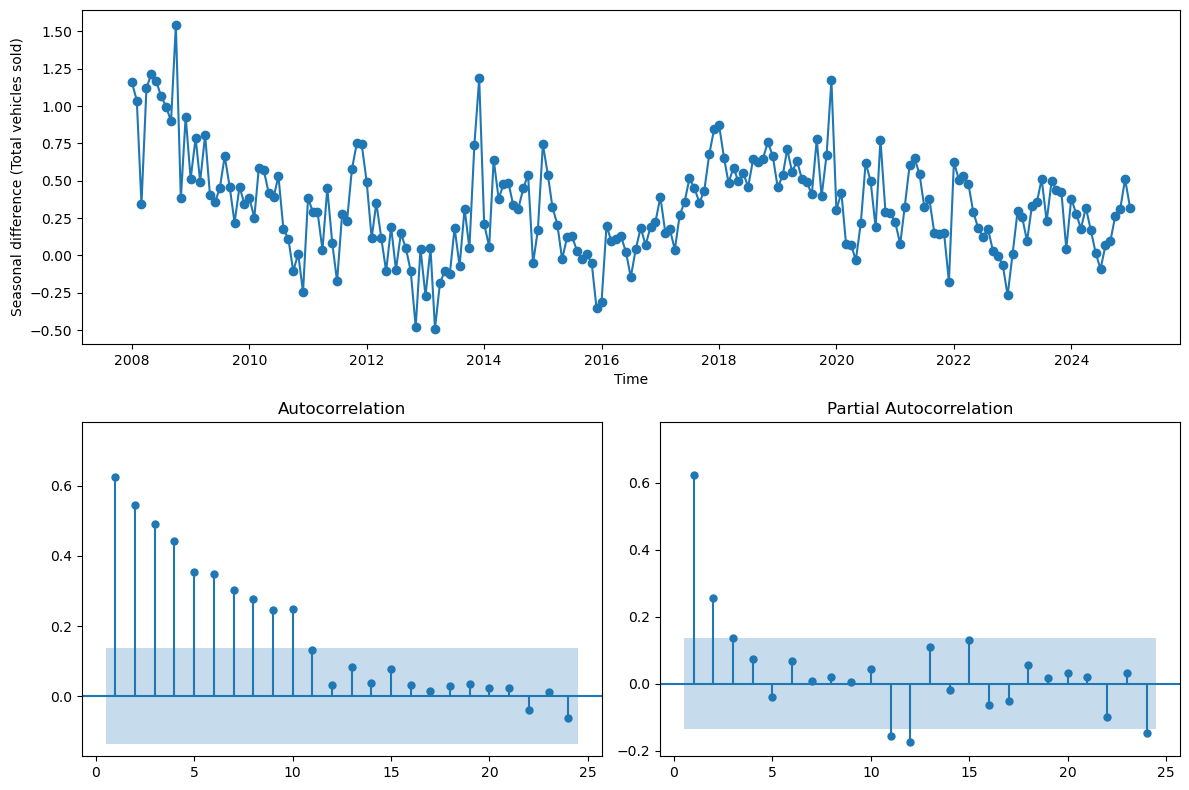

ADF Statistic (seasonal differenced): -3.5399
p-value: 0.0070
Critical Value (1%): -3.4649
Critical Value (5%): -2.8767
Critical Value (10%): -2.5749
The series is likely stationary (reject H0).


In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Calculate 12-lag (seasonal) difference of the target variable
seasonal_diff = df["BoxCox vehicles sold (Target)"].diff(12).dropna()

fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax1.plot(df["Time Period (T)"].iloc[12:], seasonal_diff, marker="o")
ax1.set_ylabel("Seasonal difference (Total vehicles sold)")
ax1.set_xlabel("Time")

plot_acf(seasonal_diff, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(seasonal_diff, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

# Perform Augmented Dickey-Fuller test on the seasonal differenced data
adf_result = adfuller(seasonal_diff)

print("ADF Statistic (seasonal differenced): {:.4f}".format(adf_result[0]))
print("p-value: {:.4f}".format(adf_result[1]))
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")





ACF Plot Interpretation:
The ACF plot shows a significant spike at lag 1, followed by a gradual decay. This pattern is characteristic of a non-seasonal MA(1) process. Additionally, there's a prominent spike at lag 12, suggesting a seasonal component at the yearly level (monthly data), indicative of seasonal MA(1).

PACF Plot Interpretation:
The PACF plot shows a strong spike at lag 1, and a possible smaller spike at lag 2, followed by a sharp decline. This pattern supports the presence of a non-seasonal AR(1) or possibly AR(2) term. A clear spike at lag 12 also appears in the PACF, followed by mild decay, suggesting a seasonal AR(1) component.

Suggested Model:
Based on the ACF and PACF patterns, a suitable model would be:
SARIMA(1,1,1)(1,1,1)[12]


In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Split data: 80% train, 10% validation, 10% test
n = len(df)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

train = df.iloc[:train_end]
val = df.iloc[train_end:val_end]
test = df.iloc[val_end:]

# Define your model configurations
model_configs = {
    "SARIMA(1,0,1)(0,1,1)[12]": {"order": (1, 0, 1), "seasonal_order": (0, 1, 1, 12)},
    "SARIMA(2,0,1)(0,1,1)[12]": {"order": (2, 0, 1), "seasonal_order": (0, 1, 1, 12)},
    "SARIMA(1,0,1)(1,1,1)[12]": {"order": (1, 0, 1), "seasonal_order": (1, 1, 1, 12)},
}

# Store results for comparison
results_summary = []

for name, config in model_configs.items():
    print(f"\nFitting model: {name}")
    
    # Fit on train set only
    model = SARIMAX(
        train["BoxCox vehicles sold (Target)"],
        order=config["order"],
        seasonal_order=config["seasonal_order"],
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    result = model.fit(disp=False)
    
    # Forecast for validation period
    val_steps = len(val)
    forecast = result.get_forecast(steps=val_steps)
    preds = forecast.predicted_mean
    actuals = val["BoxCox vehicles sold (Target)"]
    
    # Calculate metrics for validation set
    rmse = np.sqrt(mean_squared_error(actuals, preds))
    mape = mean_absolute_percentage_error(actuals, preds) * 100
    
    # Check significance of coefficients (p-values < 0.05)
    pvalues = result.pvalues
    all_significant = (pvalues < 0.05).all()
    
    # Store summary
    results_summary.append({
        "Model": name,
        "AIC (Train)": result.aic,
        "BIC (Train)": result.bic,
        "RMSE (Val)": rmse,
        "MAPE (Val)": mape,
        "All Coeffs Significant": all_significant
    })
    
    print(result.summary())

# Create a DataFrame for quick comparison
summary_df = pd.DataFrame(results_summary).sort_values("AIC (Train)")
print("\n\n📊 Model Comparison:")
print(summary_df)


Fitting model: SARIMA(1,0,1)(0,1,1)[12]
                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  217
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                  15.765
Date:                            Sat, 12 Jul 2025   AIC                            -23.530
Time:                                    13:48:23   BIC                            -10.521
Sample:                                         0   HQIC                           -18.260
                                            - 217                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9684      0.017     57.542      0.000       0.935       

Winner: SARIMAX(2,0,1)(0,1,1)[12]
Best AIC (-24.211) and log-likelihood

All coefficients statistically significant

No unnecessary seasonal AR term

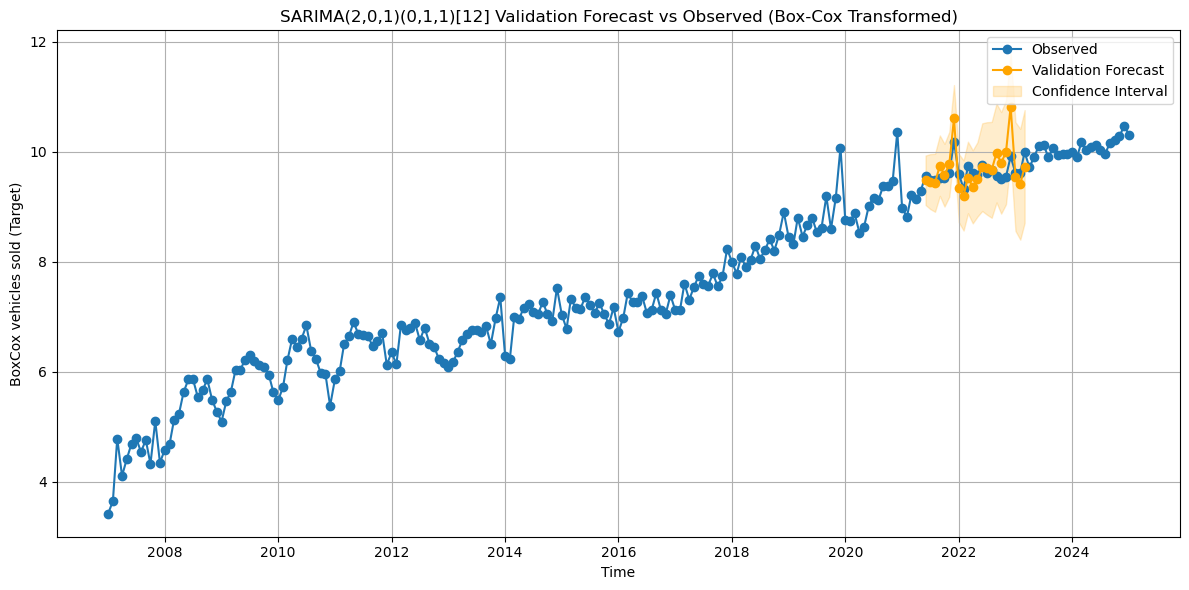

Validation Back-transformed MAPE: 0.2562
Validation Back-transformed RMSE: 8822.05


In [21]:
# Split data: 80% train, 10% validation, 10% test
n = len(df)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

train = df.iloc[:train_end]
val = df.iloc[train_end:val_end]
test = df.iloc[val_end:]

# Fit SARIMA(2,0,1)(0,1,1)[12] on train set
sarima_model = SARIMAX(
    train["BoxCox vehicles sold (Target)"],
    order=(2, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_results = sarima_model.fit()

# Forecast for validation period
val_steps = len(val)
sarima_pred = sarima_results.get_forecast(steps=val_steps)
sarima_forecast = sarima_pred.predicted_mean
sarima_conf_int = sarima_pred.conf_int()

# Create time index for validation forecasts
val_index = df["Time Period (T)"].iloc[train_end:val_end]

# Plot observed vs forecasted for validation
plt.figure(figsize=(12, 6))
plt.plot(df["Time Period (T)"], df["BoxCox vehicles sold (Target)"], label="Observed", marker='o')
plt.plot(val_index, sarima_forecast, label="Validation Forecast", color="orange", marker='o')
plt.fill_between(
    val_index,
    sarima_conf_int.iloc[:, 0],
    sarima_conf_int.iloc[:, 1],
    color="orange",
    alpha=0.2,
    label="Confidence Interval"
)
plt.title("SARIMA(2,0,1)(0,1,1)[12] Validation Forecast vs Observed (Box-Cox Transformed)")
plt.xlabel("Time")
plt.ylabel("BoxCox vehicles sold (Target)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Inverse Box-Cox transformation
def inv_boxcox(y, lam):
    if abs(lam) < 1e-6:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1 / lam)

# Get actuals for the validation period
actuals_val = df["Total vehicles sold (Target)"].iloc[train_end:val_end].values
# Back-transform forecasts
forecast_back_val = inv_boxcox(sarima_forecast.values, fitted_lambda)

# Calculate metrics for validation
mape_val = mean_absolute_percentage_error(actuals_val, forecast_back_val)
rmse_val = np.sqrt(mean_squared_error(actuals_val, forecast_back_val))

print(f"Validation Back-transformed MAPE: {mape_val:.4f}")
print(f"Validation Back-transformed RMSE: {rmse_val:.2f}")



                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  217
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                  17.105
Date:                            Fri, 11 Jul 2025   AIC                            -24.211
Time:                                    21:24:01   BIC                             -7.949
Sample:                                         0   HQIC                           -17.624
                                            - 217                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2307      0.124      9.924      0.000       0.988       1.474
ar.L2         -0.2476      0.121   

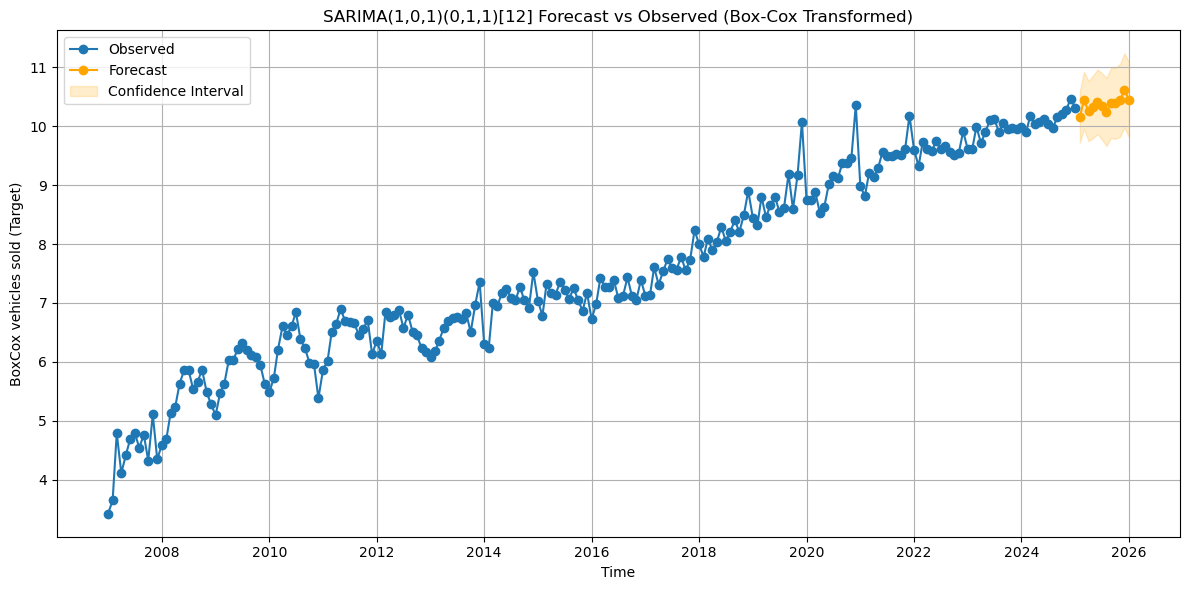

Back-transformed MAPE: 0.2636
Back-transformed RMSE: 7455.67


In [36]:
# Fit SARIMA(2,0,1)(0,1,1)[12] model on BoxCox-transformed target 
sarima_model = SARIMAX(
    df["BoxCox vehicles sold (Target)"],
    order=(2, 0, 1), 
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_results = sarima_model.fit()
print(sarima_results.summary())

# Forecast 12 steps ahead
forecast_steps = 12
sarima_pred = sarima_results.get_forecast(steps=forecast_steps)
sarima_forecast = sarima_pred.predicted_mean
sarima_conf_int = sarima_pred.conf_int()

# Create time index for forecasts
last_date = df["Time Period (T)"].iloc[-1]
sarima_forecast_index = pd.date_range(last_date, periods=forecast_steps + 1, freq='MS')[1:]

# Plot observed vs forecasted
plt.figure(figsize=(12, 6))
plt.plot(df["Time Period (T)"], df["BoxCox vehicles sold (Target)"], label="Observed", marker='o')
plt.plot(sarima_forecast_index, sarima_forecast, label="Forecast", color="orange", marker='o')
plt.fill_between(
    sarima_forecast_index,
    sarima_conf_int.iloc[:, 0],
    sarima_conf_int.iloc[:, 1],
    color="orange",
    alpha=0.2,
    label="Confidence Interval"
)
plt.title("SARIMA(1,0,1)(0,1,1)[12] Forecast vs Observed (Box-Cox Transformed)")
plt.xlabel("Time")
plt.ylabel("BoxCox vehicles sold (Target)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Inverse Box-Cox transformation
def inv_boxcox(y, lam):
    if abs(lam) < 1e-6:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1 / lam)

# Get actuals for the forecast period
actuals = df["Total vehicles sold (Target)"].iloc[-forecast_steps:].values
# Back-transform forecasts
forecast_back = inv_boxcox(sarima_forecast.values, fitted_lambda)

# Calculate metrics
mape = mean_absolute_percentage_error(actuals, forecast_back)
rmse = np.sqrt(mean_squared_error(actuals, forecast_back))

print(f"Back-transformed MAPE: {mape:.4f}")
print(f"Back-transformed RMSE: {rmse:.2f}")



## Adding Candidate predictors:
- Fiscal:
    'Company car tax rate (%)'
- google searchterms:
    Home charging (G)', 'Electric car (G)', 'Hybrid electric (G) 
- Consumer confidence:
    'Consumer confidence (E)', 'Economic climate perception (E)', 'Willingness to buy (E)'
Fuel prices:
- 'Diesel price (E)', Gasoline price (E)'


The goal/ workflow will be as followed:
1. Data Cleaning & Transformation --> Apply Box-Cox or log transform
2. Stationarity Check --> ADF + diferencing if needed
3. split data
4. Univariate SARIMAX + Lag Testing Fit SARIMAX using one predictor at a time: 
    Review:

    AIC, AICc, BIC

    Coefficient significance (results.pvalues)

    Residual autocorrelation (Ljung-Box)
    Try lagged exogenous variables to see delayed effets (e.g. search interestc may impact EV sales 1–3 months later).

repeat 1-4 until all candidate predictors are added then select stromngest preficitors 
Track metrics:

RMSE, MAE, MASE on test_df

Residual diagnostics

5. Forecast intervals
6.  Model Evaluation & Logging

## 'Company car tax rate (%)'

### 1. Data Cleaning & Transformation --> Apply Box-Cox or log transform

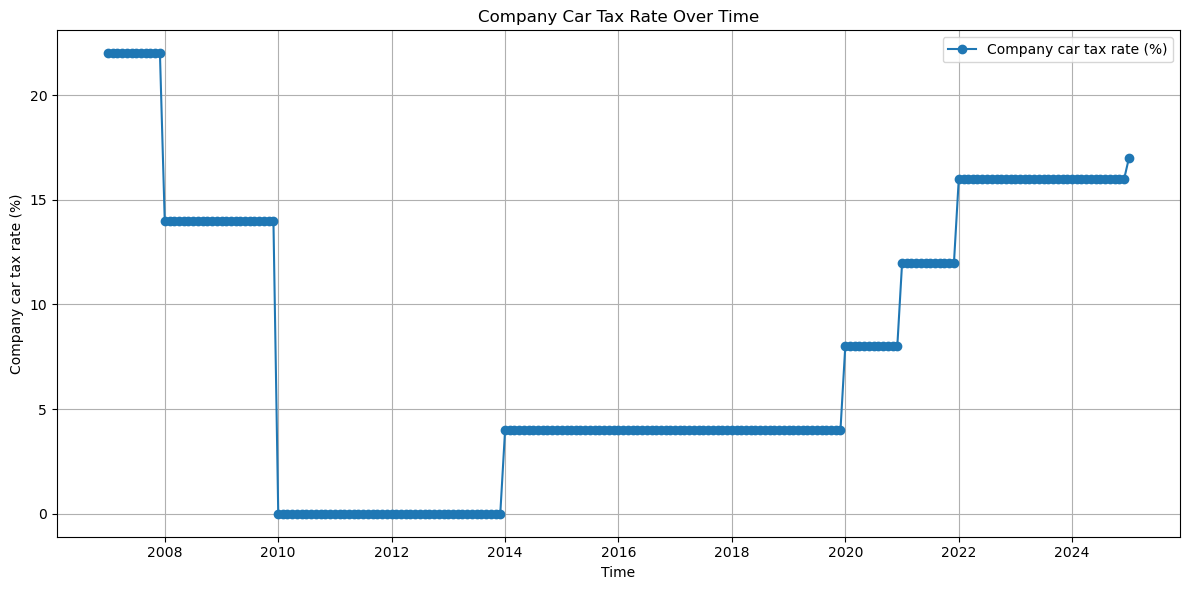

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df["Time Period (T)"], df["Company car tax rate (%)"], marker='o', label="Company car tax rate (%)")
plt.xlabel("Time")
plt.ylabel("Company car tax rate (%)")
plt.title("Company Car Tax Rate Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

I see hardly any varience in the data, so i will apply a box cox transformation to the data.

because some of thre values are 0, i will add a constant of 1 to the data before applying the box cox transformation.

Box-Cox lambda (after +1 shift): 0.3553


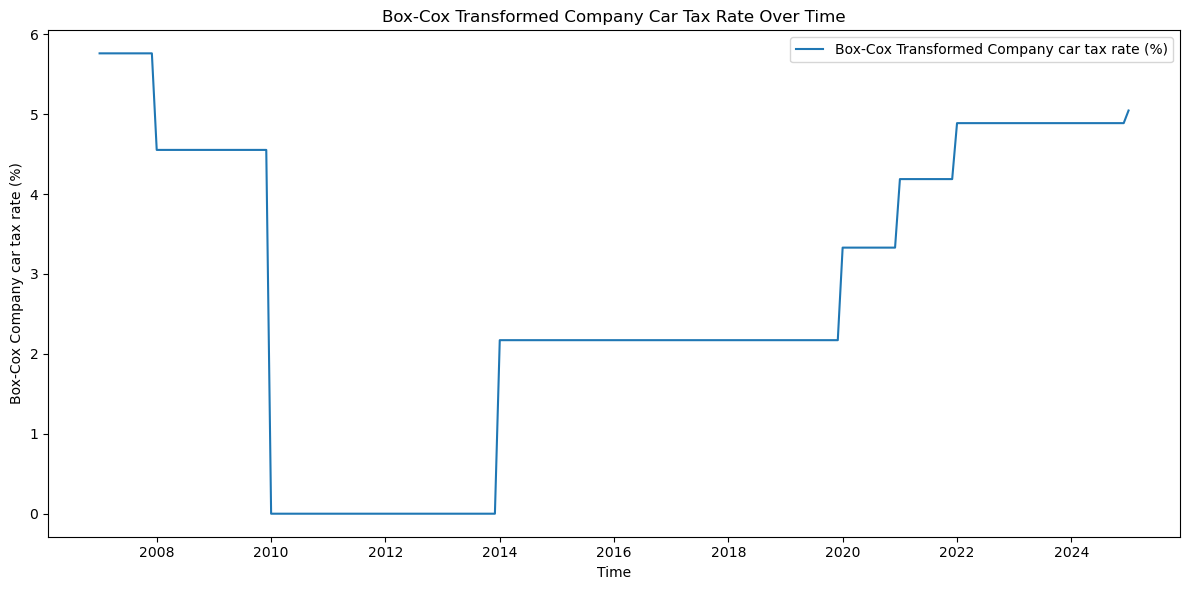

In [15]:
tax_col = "Company car tax rate (%)"
tax_values = df[tax_col].values

# Add a small shift to make all values strictly positive
tax_values_shifted = tax_values + 1

# Apply Box-Cox
tax_boxcox, tax_lambda = boxcox(tax_values_shifted)

# Save transformed values
df['BoxCox ' + tax_col] = tax_boxcox

print(f"Box-Cox lambda (after +1 shift): {tax_lambda:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(df["Time Period (T)"], tax_boxcox, label="Box-Cox Transformed Company car tax rate (%)")
plt.xlabel("Time")
plt.ylabel("Box-Cox Company car tax rate (%)")
plt.title("Box-Cox Transformed Company Car Tax Rate Over Time")
plt.legend()
plt.tight_layout()
plt.show()


Doesnt seem like the box cox transformation did much, so i will continue with checking stationarity/Differencing the data

### 2. Stationarity Check

In [17]:
# Perform Augmented Dickey-Fuller test on Box-Cox transformed (not differenced) tax rate
adf_tax_boxcox = adfuller(tax_boxcox)

print("ADF Statistic (Box-Cox tax rate): {:.4f}".format(adf_tax_boxcox[0]))
print("p-value: {:.4f}".format(adf_tax_boxcox[1]))
for key, value in adf_tax_boxcox[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_tax_boxcox[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

ADF Statistic (Box-Cox tax rate): -1.6268
p-value: 0.4692
Critical Value (1%): -3.4610
Critical Value (5%): -2.8750
Critical Value (10%): -2.5740
The series is likely non-stationary (fail to reject H0).


Looking at the adf results we can see that the p-value is 0.4692, which is much higher than the 0.05 threshold, meaning we fail to reject the null hypothesis of a unit root, indicating that the series is non-stationary.
we will continue with applying a first difference to the data to remove the trend, and then re-evaluate stationarity using the ADF test again.

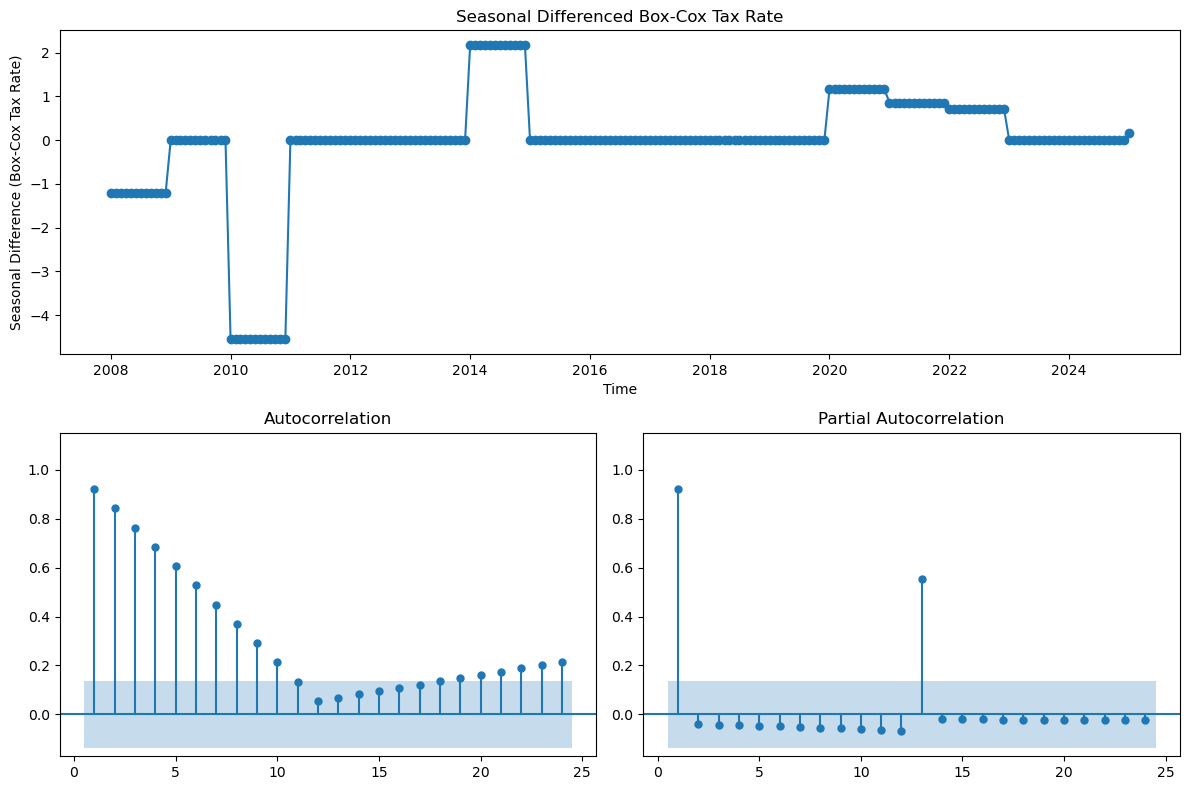

ADF Statistic (seasonal differenced): -1.9011
p-value: 0.3315
Critical Value (1%): -3.4649
Critical Value (5%): -2.8767
Critical Value (10%): -2.5749
The series is likely non-stationary (fail to reject H0).


In [18]:

# Convert tax_boxcox to Series to align with time index
tax_boxcox_series = pd.Series(tax_boxcox, index=df.index)

# Compute 12-lag seasonal difference
seasonal_diff = tax_boxcox_series.diff(12).dropna()

# Create plots
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Time-series plot
ax1.plot(df["Time Period (T)"].iloc[12:], seasonal_diff, marker="o")
ax1.set_ylabel("Seasonal Difference (Box-Cox Tax Rate)")
ax1.set_xlabel("Time")
ax1.set_title("Seasonal Differenced Box-Cox Tax Rate")

# ACF and PACF
plot_acf(seasonal_diff, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(seasonal_diff, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

# ADF Test
adf_result = adfuller(seasonal_diff)

print("ADF Statistic (seasonal differenced): {:.4f}".format(adf_result[0]))
print("p-value: {:.4f}".format(adf_result[1]))
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

after first order differencing the data, we can see that the p-value is still above the 0.05 threshold, i will apply a second order difference to the data to see if that helps with the stationarity of the data.

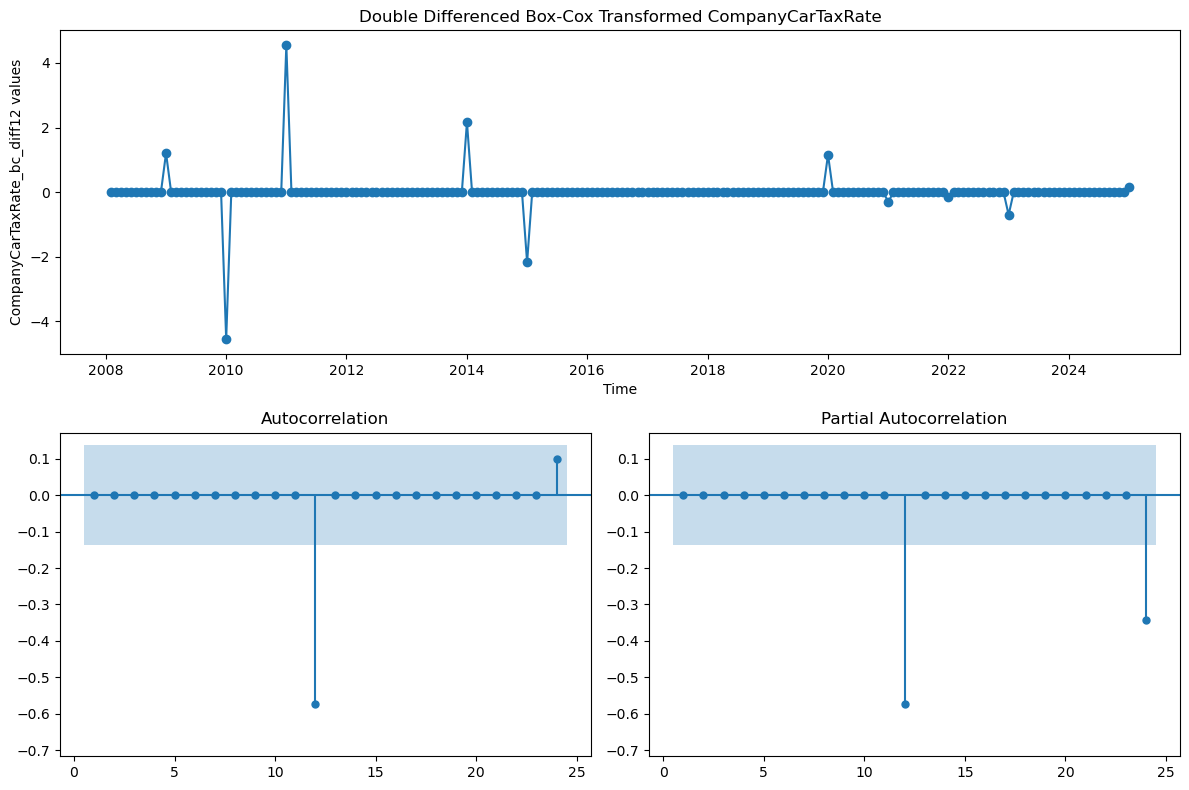

ADF Statistic (CompanyCarTaxRate_bc_diff12): -7.5682
p-value: 0.0000
Critical Value (1%): -3.4649
Critical Value (5%): -2.8767
Critical Value (10%): -2.5749
The series 'CompanyCarTaxRate_bc_diff12' is likely stationary (reject H0).


In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd

# Define a unique base name for the feature
feature_name = "CompanyCarTaxRate"
unique_prefix = f"{feature_name}_bc_diff12"

# Convert to Series (for easier indexing)
tax_boxcox_series = pd.Series(tax_boxcox, index=df.index)

# Step 1: First difference
df[f"{unique_prefix}_diff1"] = tax_boxcox_series.diff()

# Step 2: Seasonal difference after first difference
df[f"{unique_prefix}_diff1_seasonal"] = df[f"{unique_prefix}_diff1"].diff(12)

# Drop NaNs for stationarity tests and plots
stationary_series = df[f"{unique_prefix}_diff1_seasonal"].dropna()

# Plotting
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Time plot
ax1.plot(df["Time Period (T)"].iloc[13:], stationary_series, marker="o")
ax1.set_ylabel(f"{unique_prefix} values")
ax1.set_xlabel("Time")
ax1.set_title(f"Double Differenced Box-Cox Transformed {feature_name}")

# ACF and PACF
plot_acf(stationary_series, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(stationary_series, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

# ADF Test
adf_result = adfuller(stationary_series)

print(f"ADF Statistic ({unique_prefix}): {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result[1] < 0.05:
    print(f"The series '{unique_prefix}' is likely stationary (reject H0).")
else:
    print(f"The series '{unique_prefix}' is likely non-stationary (fail to reject H0).")


Now the tax data looks stationary, DAF Statistic = -7.57 is well below all critical values (1%, 5%, 10% thresholds).
p value of 0 is also well below the 0.05 threshold, meaning we can reject the null hypothesis of a unit root, indicating that the series is stationary.


### 3. Split Data

lets do 80/10/10 split for train/validation/test sets

In [26]:
# Calculate split indices for 80/10/10 split
n = len(double_diff)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

# Split the double differenced series
tax_train = double_diff.iloc[:train_end]
tax_val = double_diff.iloc[train_end:val_end]
tax_test = double_diff.iloc[val_end:]

print(f"Train length: {len(tax_train)}")
print(f"Validation length: {len(tax_val)}")
print(f"Test length: {len(tax_test)}")

# Add the cleaned predictor as exog
# Use the correct column name and align with tax_train indices
exog_train = df.loc[tax_train.index, ['CompanyCarTaxRate_bc_diff12_diff1_seasonal']]


Train length: 163
Validation length: 20
Test length: 21


### 4. Fit SARIMA model on the training set

looking at pacf plot the max lag we should test is 25

In [31]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Settings
max_lag = 25 # 👈 How many lags you'd like to test
target_series = df.loc[tax_train.index, "BoxCox vehicles sold (Target)"]

# Store results
lag_results = []

for lag in range(0, max_lag + 1):
    print(f"\n🔍 Testing lag: {lag}")
    
    # Create lagged exogenous variable
    if lag == 0:
        exog = tax_train.copy()
        label = "lag0"
    else:
        exog = tax_train.shift(lag).dropna()
        target_series_aligned = target_series.loc[exog.index]
        label = f"lag{lag}"
    
    # Align target series and exog
    if lag == 0:
        model_target = target_series
    else:
        model_target = target_series_aligned
    
    # Fit SARIMAX
    model = SARIMAX(
        model_target,
        exog=exog,
        order=(2, 0, 1),
        seasonal_order=(0, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    results = model.fit(disp=False)
    summary = results.summary()
    print(summary)

    # Log metrics
    lag_results.append({
        "Lag": label,
        "AIC": results.aic,
        "BIC": results.bic,
        "Coefficient p-value": results.pvalues.get(label, None),
        "Log Likelihood": results.llf
    })

# Compare results in a DataFrame
lag_df = pd.DataFrame(lag_results).sort_values("AIC")
print("\n📊 Lag Comparison Summary:")
print(lag_df)



🔍 Testing lag: 0


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  163
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   6.572
Date:                            Sat, 12 Jul 2025   AIC                             -1.143
Time:                                    15:47:30   BIC                             16.376
Sample:                                         0   HQIC                             5.976
                                            - 163                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0032      0.015     -0.218      0.827      -0.032       0.026
ar.L1          1.2836      0.149   

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  162
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   6.320
Date:                            Sat, 12 Jul 2025   AIC                             -0.641
Time:                                    15:47:32   BIC                             16.835
Sample:                                         0   HQIC                             6.461
                                            - 162                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0025      0.045     -0.056      0.955      -0.091       0.086
ar.L1          1.2773      0.147   

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  161
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   6.258
Date:                            Sat, 12 Jul 2025   AIC                             -0.517
Time:                                    15:47:34   BIC                             16.915
Sample:                                         0   HQIC                             6.567
                                            - 161                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0125      0.045      0.275      0.783      -0.076       0.101
ar.L1          1.2930      0.150   

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  160
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   6.085
Date:                            Sat, 12 Jul 2025   AIC                             -0.171
Time:                                    15:47:36   BIC                             17.216
Sample:                                         0   HQIC                             6.895
                                            - 160                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0271      0.033     -0.822      0.411      -0.092       0.038
ar.L1          1.3048      0.144   

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  159
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   6.279
Date:                            Sat, 12 Jul 2025   AIC                             -0.558
Time:                                    15:47:39   BIC                             16.784
Sample:                                         0   HQIC                             6.489
                                            - 159                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0380      0.059      0.644      0.519      -0.078       0.154
ar.L1          1.3056      0.149   

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  158
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   5.271
Date:                            Sat, 12 Jul 2025   AIC                              1.457
Time:                                    15:47:41   BIC                             18.754
Sample:                                         0   HQIC                             8.486
                                            - 158                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0192      0.034     -0.559      0.576      -0.087       0.048
ar.L1          1.2833      0.151   

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  157
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   5.555
Date:                            Sat, 12 Jul 2025   AIC                              0.891
Time:                                    15:47:42   BIC                             18.142
Sample:                                         0   HQIC                             7.900
                                            - 157                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0236      0.036     -0.658      0.510      -0.094       0.047
ar.L1          1.2585      0.148   

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  156
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   5.962
Date:                            Sat, 12 Jul 2025   AIC                              0.077
Time:                                    15:47:44   BIC                             17.282
Sample:                                         0   HQIC                             7.068
                                            - 156                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0088      0.048      0.184      0.854      -0.085       0.103
ar.L1          1.2856      0.138   

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  155
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   5.483
Date:                            Sat, 12 Jul 2025   AIC                              1.035
Time:                                    15:47:45   BIC                             18.193
Sample:                                         0   HQIC                             8.007
                                            - 155                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0136      0.042     -0.323      0.747      -0.096       0.069
ar.L1          1.2644      0.142   

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  154
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   6.422
Date:                            Sat, 12 Jul 2025   AIC                             -0.844
Time:                                    15:47:48   BIC                             16.268
Sample:                                         0   HQIC                             6.108
                                            - 154                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0195      0.028      0.700      0.484      -0.035       0.074
ar.L1          1.2698      0.136   

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  153
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   7.819
Date:                            Sat, 12 Jul 2025   AIC                             -3.638
Time:                                    15:47:50   BIC                             13.427
Sample:                                         0   HQIC                             3.295
                                            - 153                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0279      0.028      0.994      0.320      -0.027       0.083
ar.L1          1.2556      0.143   

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  152
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   6.789
Date:                            Sat, 12 Jul 2025   AIC                             -1.578
Time:                                    15:47:51   BIC                             15.440
Sample:                                         0   HQIC                             5.336
                                            - 152                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0145      0.037      0.396      0.692      -0.057       0.086
ar.L1          1.2614      0.144   

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  151
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   8.198
Date:                            Sat, 12 Jul 2025   AIC                             -4.396
Time:                                    15:47:53   BIC                             12.574
Sample:                                         0   HQIC                             2.498
                                            - 151                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0454      0.023      1.937      0.053      -0.001       0.091
ar.L1          1.2914      0.142   

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  150
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   7.714
Date:                            Sat, 12 Jul 2025   AIC                             -3.429
Time:                                    15:47:55   BIC                             13.493
Sample:                                         0   HQIC                             3.445
                                            - 150                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0422      0.050     -0.836      0.403      -0.141       0.057
ar.L1          1.3237      0.148   

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  149
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   7.375
Date:                            Sat, 12 Jul 2025   AIC                             -2.750
Time:                                    15:47:57   BIC                             14.123
Sample:                                         0   HQIC                             4.104
                                            - 149                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0295      0.037      0.790      0.430      -0.044       0.103
ar.L1          1.3330      0.141   

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  148
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   6.477
Date:                            Sat, 12 Jul 2025   AIC                             -0.955
Time:                                    15:47:58   BIC                             15.869
Sample:                                         0   HQIC                             5.879
                                            - 148                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0105      0.026     -0.400      0.689      -0.062       0.041
ar.L1          1.2981      0.150   

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  147
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   6.437
Date:                            Sat, 12 Jul 2025   AIC                             -0.875
Time:                                    15:47:59   BIC                             15.900
Sample:                                         0   HQIC                             5.938
                                            - 147                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0144      0.045     -0.317      0.751      -0.103       0.075
ar.L1          1.2813      0.156   

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  146
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   6.379
Date:                            Sat, 12 Jul 2025   AIC                             -0.759
Time:                                    15:48:01   BIC                             15.966
Sample:                                         0   HQIC                             6.034
                                            - 146                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0237      0.032      0.739      0.460      -0.039       0.086
ar.L1          1.3299      0.152   

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  145
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   5.867
Date:                            Sat, 12 Jul 2025   AIC                              0.266
Time:                                    15:48:02   BIC                             16.941
Sample:                                         0   HQIC                             7.037
                                            - 145                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0247      0.026     -0.944      0.345      -0.076       0.027
ar.L1          1.3509      0.148   

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  144
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   6.484
Date:                            Sat, 12 Jul 2025   AIC                             -0.968
Time:                                    15:48:04   BIC                             15.656
Sample:                                         0   HQIC                             5.782
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0276      0.061      0.449      0.653      -0.093       0.148
ar.L1          1.3062      0.154   

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  143
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   6.691
Date:                            Sat, 12 Jul 2025   AIC                             -1.381
Time:                                    15:48:06   BIC                             15.192
Sample:                                         0   HQIC                             5.347
                                            - 143                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0151      0.052     -0.287      0.774      -0.118       0.088
ar.L1          1.2809      0.154   

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  142
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   6.352
Date:                            Sat, 12 Jul 2025   AIC                             -0.704
Time:                                    15:48:08   BIC                             15.817
Sample:                                         0   HQIC                             6.002
                                            - 142                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0175      0.026      0.661      0.509      -0.034       0.069
ar.L1          1.2642      0.155   

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  141
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   6.264
Date:                            Sat, 12 Jul 2025   AIC                             -0.527
Time:                                    15:48:10   BIC                             15.943
Sample:                                         0   HQIC                             6.158
                                            - 141                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0412      0.029     -1.440      0.150      -0.097       0.015
ar.L1          1.2478      0.155   

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  140
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   5.627
Date:                            Sat, 12 Jul 2025   AIC                              0.745
Time:                                    15:48:12   BIC                             17.162
Sample:                                         0   HQIC                             7.408
                                            - 140                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0075      0.020      0.376      0.707      -0.032       0.047
ar.L1          1.2350      0.160   

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  138
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   6.707
Date:                            Sat, 12 Jul 2025   AIC                             -1.413
Time:                                    15:48:16   BIC                             14.898
Sample:                                         0   HQIC                             5.204
                                            - 138                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0370      0.027      1.383      0.167      -0.015       0.089
ar.L1          1.2502      0.181   

lag 12 came best out of the box, so i will use that as a seasonal lag

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    df.loc[tax_train.index, "BoxCox vehicles sold (Target)"],
    exog=tax_train,
    order=(2, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
print(results.summary())



c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  163
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   6.572
Date:                            Sat, 12 Jul 2025   AIC                             -1.143
Time:                                    15:41:41   BIC                             16.376
Sample:                                         0   HQIC                             5.976
                                            - 163                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0032      0.015     -0.218      0.827      -0.032       0.026
ar.L1          1.2836      0.149   

### 5. evaluate model

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  151
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   8.198
Date:                            Sat, 12 Jul 2025   AIC                             -4.396
Time:                                    16:00:27   BIC                             12.574
Sample:                                         0   HQIC                             2.498
                                            - 151                                         
Covariance Type:                              opg                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
CompanyCarTaxRate_bc_diff12_diff1_seasonal

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


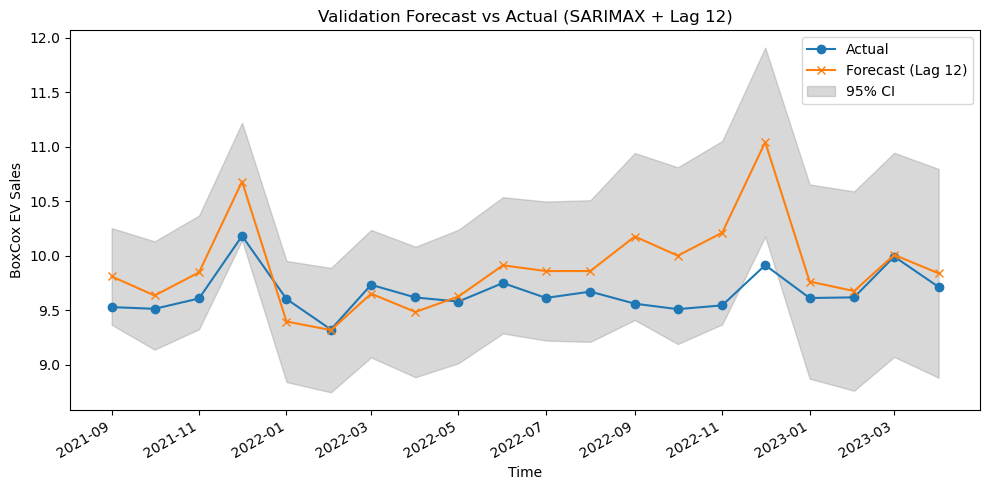

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1️⃣ Prepare lagged exogenous predictor for train/val split
df['CompanyCarTaxRate_bc_diff12_diff1_seasonal_L12'] = df['CompanyCarTaxRate_bc_diff12_diff1_seasonal'].shift(12)

tax_lag12_train = df['CompanyCarTaxRate_bc_diff12_diff1_seasonal_L12'].loc[tax_train.index]
tax_lag12_val = df['CompanyCarTaxRate_bc_diff12_diff1_seasonal_L12'].loc[tax_val.index]

target_train = df['BoxCox vehicles sold (Target)'].loc[tax_train.index]
target_val = df['BoxCox vehicles sold (Target)'].loc[tax_val.index]

# Drop rows with NaN in exog for training
train_mask = ~tax_lag12_train.isna()
tax_lag12_train_clean = tax_lag12_train[train_mask]
target_train_clean = target_train[train_mask]

# 2️⃣ Fit SARIMAX model
model = SARIMAX(
    target_train_clean,
    exog=tax_lag12_train_clean,
    order=(2, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
print(results.summary())

# Align validation exog and target (drop NaNs in exog)
val_mask = ~tax_lag12_val.isna()
tax_lag12_val_clean = tax_lag12_val[val_mask]
target_val_clean = target_val[val_mask]

# 3️⃣ Forecast validation set
forecast = results.get_forecast(steps=len(tax_lag12_val_clean), exog=tax_lag12_val_clean)
preds = forecast.predicted_mean
conf_int = forecast.conf_int()

# 4️⃣ Evaluate performance
rmse = np.sqrt(mean_squared_error(target_val_clean, preds))
mape = mean_absolute_percentage_error(target_val_clean, preds) * 100

print(f"\n📊 Forecast Evaluation (Validation Set):")
print(f"RMSE (BoxCox): {rmse:.4f}")
print(f"MAPE (BoxCox): {mape:.2f}%")

# Back-transform predictions and actuals to original scale
def inv_boxcox(y, lam):
    if abs(lam) < 1e-6:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1 / lam)

# Use the same lambda as used for Box-Cox on the target
preds_back = inv_boxcox(preds.values, fitted_lambda)
actuals_back = inv_boxcox(target_val_clean.values, fitted_lambda)

rmse_back = np.sqrt(mean_squared_error(actuals_back, preds_back))
mape_back = mean_absolute_percentage_error(actuals_back, preds_back) * 100

print(f"RMSE (Back-transformed): {rmse_back:.2f}")
print(f"MAPE (Back-transformed): {mape_back:.2f}%")
# 5️⃣ Plot actual vs predicted with date-formatted x-axis
fig, ax = plt.subplots(figsize=(10, 5))
val_dates = df.loc[target_val_clean.index, "Time Period (T)"]
ax.plot(val_dates, target_val_clean, label="Actual", marker='o')
ax.plot(val_dates, preds, label="Forecast (Lag 12)", marker='x')
ax.fill_between(val_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label="95% CI")
ax.set_title("Validation Forecast vs Actual (SARIMAX + Lag 12)")
ax.set_xlabel("Time")
ax.set_ylabel("BoxCox EV Sales")
ax.legend()
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()
